In [1]:
import qiskit
import qiskit_aer
import numpy
import matplotlib.pyplot as plt
import random
import time
from qiskit import Aer, execute, QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info import Statevector, DensityMatrix, entropy
from qiskit.circuit.random import random_circuit
import pickle

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Creating a Random Circuit

In [2]:
def create_periodic_random(num_qubits, period, layers, draw=False) :
    single_gates = [
    lambda qc, qubit: qc.h(qubit),
    lambda qc, qubit: qc.s(qubit),
    lambda qc, qubit: qc.sdg(qubit),
    lambda qc, qubit: qc.t(qubit),
    lambda qc, qubit: qc.tdg(qubit),
    lambda qc, qubit: qc.rx(3.14, qubit),
    lambda qc, qubit: qc.ry(3.14, qubit),
    lambda qc, qubit: qc.rz(3.14, qubit),
    lambda qc, qubit: qc.p(3.14, qubit),
    lambda qc, qubit: qc.sx(qubit),
    lambda qc, qubit: qc.i(qubit) ]
    qc = QuantumCircuit(num_qubits, num_qubits)
    for l in range(layers) :
        for k in range(period) :
            for i in range(num_qubits) :
                rs = random.randint(0,10)
                single_gates[rs](qc, i)
    return qc

In [3]:
def create_periodic_random_entangled(num_qubits, period, layers, draw=False) :
    single_gates = [
    lambda qc, qubit: qc.h(qubit),
    lambda qc, qubit: qc.s(qubit),
    lambda qc, qubit: qc.sdg(qubit),
    lambda qc, qubit: qc.t(qubit),
    lambda qc, qubit: qc.tdg(qubit),
    lambda qc, qubit: qc.rx(3.14, qubit),
    lambda qc, qubit: qc.ry(3.14, qubit),
    lambda qc, qubit: qc.rz(3.14, qubit),
    lambda qc, qubit: qc.p(3.14, qubit),
    lambda qc, qubit: qc.sx(qubit),
    lambda qc, qubit: qc.i(qubit) ]
    multi_gates = [
    lambda qc, qubit: qc.cx(qubit, qubit+1),
    lambda qc, qubit: qc.cy(qubit, qubit+1),
    lambda qc, qubit: qc.cz(qubit, qubit+1),
    lambda qc, qubit: qc.swap(qubit, qubit+1),
    lambda qc, qubit: qc.crx(3.14, qubit, qubit+1),
    lambda qc, qubit: qc.cry(3.14, qubit, qubit+1),
    lambda qc, qubit: qc.crz(3.14, qubit, qubit+1),
    lambda qc, qubit: qc.rxx(3.14, qubit, qubit+1) ]
    qc = QuantumCircuit(num_qubits, num_qubits)
    for l in range(layers) :
        for k in range(period) :
            for i in range(num_qubits) :
                rs = random.randint(0,10)
                rm = random.randint(0,7)
                coin = random.randint(0,1)
                if coin :
                    single_gates[rs](qc, i)
                else :
                    if i == (num_qubits-1) :
                        multi_gates[rm](qc,i-1)
                    else :
                        multi_gates[rm](qc,i)
    return qc

## Calculating Shannon Entropy

In [4]:
def calculate_shannon_entropy(qc, num, draw=False) :
    backend = qiskit_aer.Aer.get_backend('statevector_simulator')
    new_qc = transpile(qc, backend=backend)
    job = backend.run(new_qc, shots = 1024)
    result = job.result()
    outputstate = result.get_statevector()
    probs = Statevector(outputstate).probabilities()
    shan = shentropy(probs, base=2)
    
    if draw :
        display(qiskit.visualization.plot_state_city(outputstate))
        display(qc.draw(style='iqp'))

    return shan

def shentropy(pvec, base) :
    if base == 2:

        def logfn(x):
            return -x * numpy.log2(x)
    elif base == np.e:

        def logfn(x):
            return -x * numpy.log(x)
    else:

        def logfn(x):
            return -x * numpy.log(x) / numpy.log(base)

    h = 0.
    for x in pvec:
        if 0 < x < 1:
            h += logfn(x)
    return h

## Gathering the Results

In [5]:
from itertools import product

def gather_results(num_qubits, num_trials, layers, draw=False) :
    results = []
    qc = create_periodic_random(num_qubits, num_qubits, layers)
    if(draw) :
        display(qc.draw())
    bases = xyz_list(num_qubits)
    for i in range(num_trials) : 
        temp = qc.copy()
        for b in bases :
            for q in range(num_qubits) :
                if b[q] == 'x' :
                    temp.h(q)
                elif b[q] == 'y' :
                    temp.sdg(q)
                    temp.h(q)
            entropy = calculate_shannon_entropy(temp, num_qubits, False)
            entropy = entropy/num_qubits
            results.append((b, entropy))
            temp.clear()
    return results
        

def xyz_list(num):
    
    permutations = product('xyz', repeat=num)
    result = [''.join(p) for p in permutations]
    return result

In [6]:
from itertools import product

def gather_results_entangled(num_qubits, num_trials, layers, draw=False) :
    results = []
    qc = create_periodic_random_entangled(num_qubits, num_qubits, layers)
    if(draw) :
        display(qc.draw())
    bases = xyz_list(num_qubits)
    for i in range(num_trials) : 
        temp = qc.copy()
        for b in bases :
            for q in range(num_qubits) :
                if b[q] == 'x' :
                    temp.h(q)
                elif b[q] == 'y' :
                    temp.sdg(q)
                    temp.h(q)
            entropy = calculate_shannon_entropy(temp, num_qubits, False)
            entropy = entropy/num_qubits
            results.append((b, entropy))
            temp.clear()
    return results
        

def xyz_list(num):
    
    permutations = product('xyz', repeat=num)
    result = [''.join(p) for p in permutations]
    return result

## Plot the Histogram with 10 Bins Including Basis Counts

I want to use 10 bins in my histogram so that the data isn't oversimplified (with larger bins and less of them, it is harder to see how the data transforms for systems with different numbers of qubits). With 10 bins, I can see which regions received the most counts, which received some counts, and which received none.

In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

def plot_entropy_histogram(data):
    bin_edges = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    bin_labels = ["0.0-0.1", "0.1-0.2", "0.2-0.3", "0.3-0.4", "0.4-0.5", "0.5-0.6", "0.6-0.7", "0.7-0.8", "0.8-0.9", "0.9-1.0"]
    entropy_bins = defaultdict(list)
    
    for base, entropy in data:
        bin_index = int(entropy * 10)
        entropy_bins[bin_index].append(base)

    counts = [len(entropy_bins[i]) for i in range(10)]

    plt.figure(figsize=(10, 5))
    plt.bar(bin_labels, counts, color='blue', edgecolor='black')
    plt.xlabel('Entropy Intervals')
    plt.ylabel('Count')
    plt.title('Histogram of Data by Entropy Intervals')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    for i in range(len(bin_edges)):
        if entropy_bins[i]:
            common_bases = Counter(entropy_bins[i])
            most_common_base = common_bases.most_common(1)[0]
            print(f"Most common base in {bin_labels[i]}: {most_common_base[0]}")



## Exporting and Importing data from Pickle

In [8]:
def generate_data(num_qubits, trials, layers, filename, draw=False) :
    data = gather_results(num_qubits, trials, layers, draw)

    with open(filename, 'wb') as file:
        pickle.dump(data, file)

In [9]:
def generate_entangled_data(num_qubits, trials, layers, filename, draw=False) :
    data = gather_results_entangled(num_qubits, trials, layers, draw)

    with open(filename, 'wb') as file:
        pickle.dump(data, file)

In [10]:
def plot_hist_10(filename) :
    arr = []
    with open(filename, 'rb') as file:
        arr = pickle.load(file)
    plot_entropy_histogram(arr)

# NOTE: File Naming
I have named all of the files according to the template: 'hist_#qubits_#layers_e/ne.pkl'
e/ne denotes if the circuit was entangled (e) or not entangled (ne). For example, a 4 qubit system with 2 layers that has entanglement would be located under the filename 'hist_4q_2l_e.pkl'.

In [25]:
generate_data(3, 100, 1, 'hist_3q_1l_ne.pkl', True)

┌─────┐      ┌───┐    ┌───┐ 
q_0: ──┤ Sdg ├──────┤ S ├────┤ T ├─
     ┌─┴─────┴──┐  ┌┴───┴┐   ├───┴┐
q_1: ┤ Rx(3.14) ├──┤ Tdg ├───┤ √X ├
     └──┬───┬───┘┌─┴─────┴─┐┌┴────┤
q_2: ───┤ H ├────┤ P(3.14) ├┤ Sdg ├
        └───┘    └─────────┘└─────┘
c: 3/══════════════════════════════

In [26]:
generate_data(4, 100, 1, 'hist_4q_1l_ne.pkl', True)

┌─────┐   ┌───┐ ┌──────────┐┌──────────┐
q_0: ──┤ Tdg ├───┤ T ├─┤ Rx(3.14) ├┤ Rz(3.14) ├
       ├─────┤   ├───┤ └──┬────┬──┘└──┬────┬──┘
q_1: ──┤ Tdg ├───┤ H ├────┤ √X ├──────┤ √X ├───
     ┌─┴─────┴──┐├───┴┐┌──┴────┴──┐  ┌┴────┤   
q_2: ┤ Rz(3.14) ├┤ √X ├┤ Rx(3.14) ├──┤ Tdg ├───
     ├──────────┤├────┤├─────────┬┘┌─┴─────┴──┐
q_3: ┤ Rx(3.14) ├┤ √X ├┤ P(3.14) ├─┤ Ry(3.14) ├
     └──────────┘└────┘└─────────┘ └──────────┘
c: 4/══════════════════════════════════════════

In [27]:
generate_data(5, 100, 1, 'hist_5q_1l_ne.pkl', True)

┌─────┐      ┌───┐    ┌───┐    ┌────┐    ┌───┐ 
q_0: ──┤ Sdg ├──────┤ I ├────┤ T ├────┤ √X ├────┤ H ├─
       └┬────┤      ├───┤    ├───┤ ┌──┴────┴─┐ ┌┴───┴┐
q_1: ───┤ √X ├──────┤ S ├────┤ I ├─┤ P(3.14) ├─┤ Sdg ├
        ├───┬┘   ┌──┴───┴───┐├───┤ ├─────────┴┐├─────┤
q_2: ───┤ I ├────┤ Rx(3.14) ├┤ H ├─┤ Ry(3.14) ├┤ Sdg ├
        ├───┤    ├──────────┤├───┤ └─┬─────┬──┘├─────┤
q_3: ───┤ T ├────┤ Rz(3.14) ├┤ I ├───┤ Sdg ├───┤ Sdg ├
     ┌──┴───┴───┐└──┬───┬───┘├───┴┐  └┬───┬┘   └┬───┬┘
q_4: ┤ Rz(3.14) ├───┤ I ├────┤ √X ├───┤ T ├─────┤ S ├─
     └──────────┘   └───┘    └────┘   └───┘     └───┘ 
c: 5/═════════════════════════════════════════════════

In [28]:
generate_entangled_data(3, 100, 1, 'hist_3q_1l_e.pkl', True)

┌─────┐            ┌────────────┐  ┌─────┐                       
q_0: ┤ Sdg ├────────────┤0           ├──┤ Sdg ├───────────────────────
     └─────┘            │  Rxx(3.14) │┌─┴─────┴──┐            ┌───┐   
q_1: ───■────────■──────┤1           ├┤ Rx(3.14) ├─────■──────┤ I ├─X─
        │   ┌────┴─────┐└────────────┘└──────────┘┌────┴─────┐└───┘ │ 
q_2: ───■───┤ Ry(3.14) ├──────────────────────────┤ Rx(3.14) ├──────X─
            └──────────┘                          └──────────┘        
c: 3/═════════════════════════════════════════════════════════════════

In [29]:
generate_entangled_data(4, 100, 1, 'hist_4q_1l_e.pkl', True)

┌──────────┐┌──────────┐┌─────┐┌─────────┐                              »
q_0: ┤ Rx(3.14) ├┤ Rz(3.14) ├┤ Tdg ├┤ P(3.14) ├──────────────────────────────»
     └──────────┘└──┬───┬───┘└─────┘└─────────┘                              »
q_1: ─────■─────────┤ T ├──────────────────────────■──────────────────────■──»
        ┌─┴─┐      ┌┴───┴┐                       ┌─┴─┐                  ┌─┴─┐»
q_2: ───┤ X ├──────┤ Tdg ├──────■────────■───────┤ X ├──────■────────■──┤ X ├»
        └───┘      └─────┘    ┌─┴─┐ ┌────┴─────┐┌┴───┴┐┌────┴─────┐┌─┴─┐└───┘»
q_3: ─────────────────────────┤ Y ├─┤ Ry(3.14) ├┤ Sdg ├┤ Rz(3.14) ├┤ X ├─────»
                              └───┘ └──────────┘└─────┘└──────────┘└───┘     »
c: 4/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                      
«q_0: ─────────────────
«                      
«q_1: ─────────────────
«                      
«q_2: ──■──────────────
«     ┌─┴─┐┌──────────┐
«q_3: ┤ Y ├┤ Rx(3.14) ├
«     └───┘└──────────┘
«c: 4/═════════════════
«

In [30]:
generate_entangled_data(5, 100, 1, 'hist_5q_1l_e.pkl', True)

┌───┐                                                      »
q_0: ─────■────────┤ H ├───────────X─────────■────────────────■───────────────»
        ┌─┴─┐   ┌──┴───┴───┐┌───┐  │       ┌─┴─┐┌─────────┐   │     ┌─────┐   »
q_1: ───┤ X ├───┤ Ry(3.14) ├┤ S ├──X────■──┤ X ├┤ P(3.14) ├───■─────┤ Sdg ├───»
     ┌──┴───┴──┐└──────────┘└───┘     ┌─┴─┐└───┘├─────────┤┌─────┐  └─────┘   »
q_2: ┤ P(3.14) ├─────X────────────────┤ Y ├──■──┤ P(3.14) ├┤ Tdg ├────────────»
     └─────────┘     │                └───┘  │  └─────────┘└─────┘            »
q_3: ─────■──────────X────────■──────────────■───────X────────X────────■──────»
          │       ┌─────┐   ┌─┴─┐┌───┐               │        │   ┌────┴─────┐»
q_4: ─────■───────┤ Tdg ├───┤ X ├┤ I ├───────────────X────────X───┤ Ry(3.14) ├»
                  └─────┘   └───┘└───┘                            └──────────┘»
c: 5/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                             
«q_0: ────────────────────────
«                             
«q_1: ────────────────────────
«                             
«q_2: ────────────────────────
«                 ┌─────┐     
«q_3: ─────■──────┤ Sdg ├──■──
«     ┌────┴─────┐└─────┘┌─┴─┐
«q_4: ┤ Rz(3.14) ├───────┤ X ├
«     └──────────┘       └───┘
«c: 5/════════════════════════
«

# Entropy Profile for a Random 3 Qubit Circuit (No Entanglement)

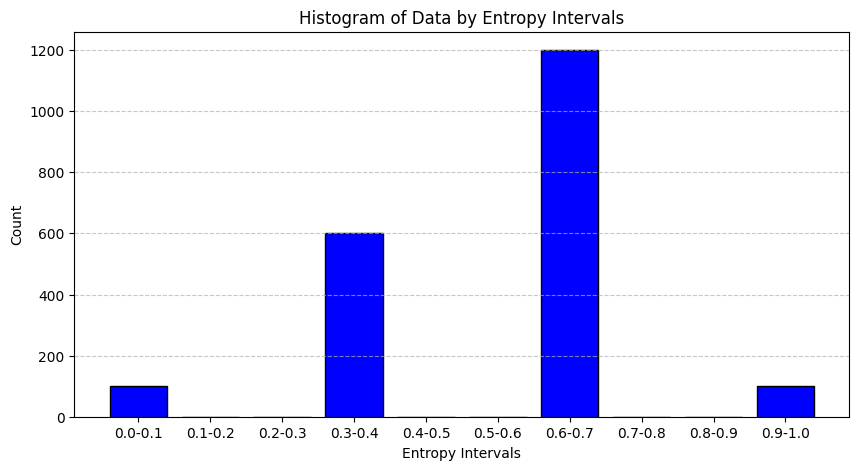

Most common base in 0.0-0.1: zzz
Most common base in 0.3-0.4: xzz
Most common base in 0.6-0.7: xxz
Most common base in 0.9-1.0: xxx


In [11]:
plot_hist_10('hist_3q_1l_ne.pkl')

# Entropy Profile for a Random 4 Qubit Circuit (No Entanglement)

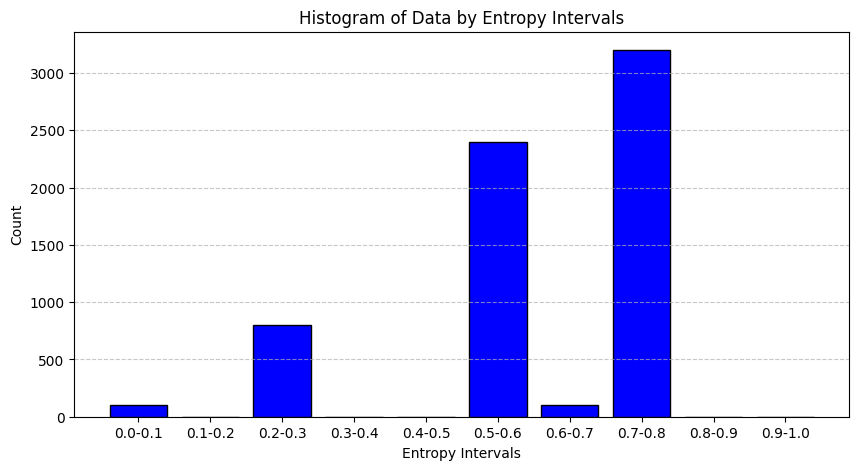

Most common base in 0.0-0.1: zzzz
Most common base in 0.2-0.3: xzzz
Most common base in 0.5-0.6: xxzz
Most common base in 0.6-0.7: xxxx
Most common base in 0.7-0.8: xxxz


In [32]:
plot_hist_10('hist_4q_1l_ne.pkl')

# Entropy Profile for a Random 5 Qubit Circuit (No Entanglement)

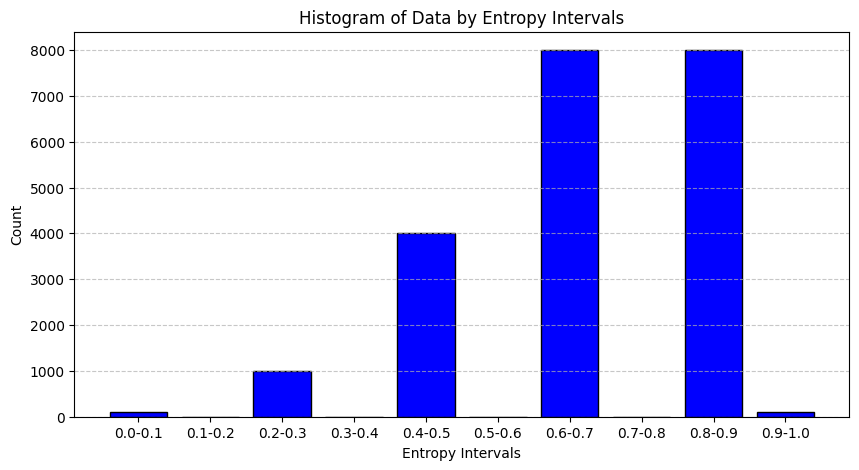

Most common base in 0.0-0.1: zzzzz
Most common base in 0.2-0.3: xzzzz
Most common base in 0.4-0.5: xxzzz
Most common base in 0.6-0.7: xxxzz
Most common base in 0.8-0.9: xxxxz
Most common base in 0.9-1.0: xxxxx


In [33]:
plot_hist_10('hist_5q_1l_ne.pkl')

# Entropy Profile for a Random 3 Qubit Circuit (With Entanglement)

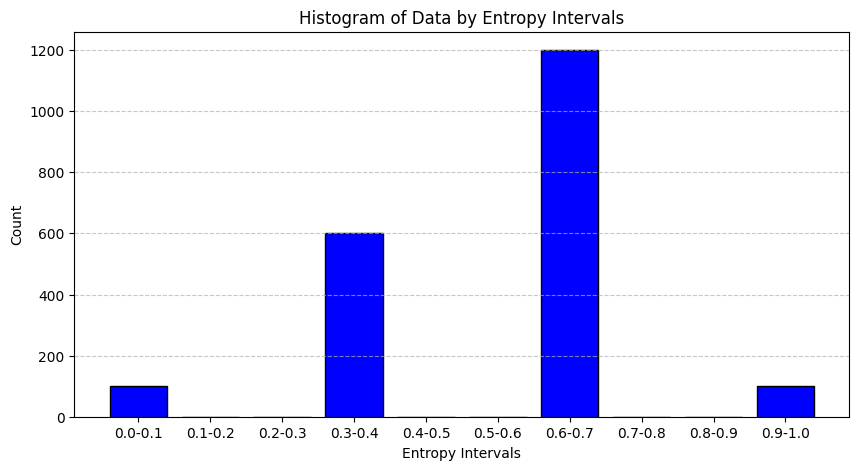

Most common base in 0.0-0.1: zzz
Most common base in 0.3-0.4: xzz
Most common base in 0.6-0.7: xxz
Most common base in 0.9-1.0: xxx


In [34]:
plot_hist_10('hist_3q_1l_e.pkl')

# Entropy Profile for a Random 4 Qubit Circuit (With Entanglement)

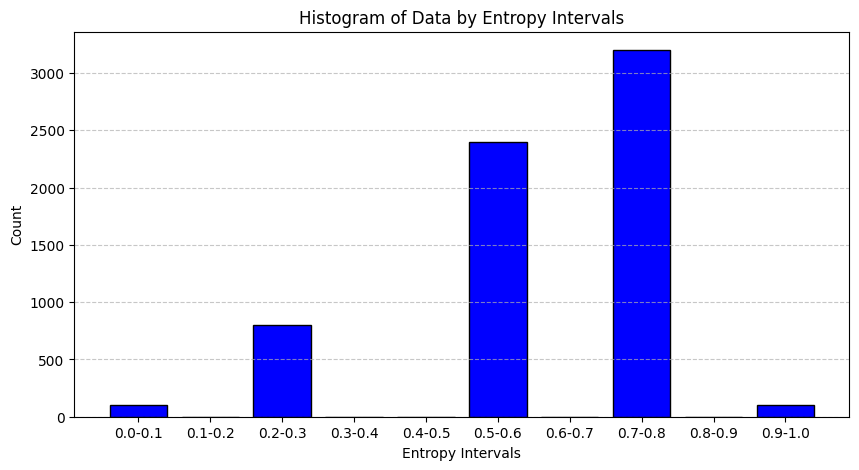

Most common base in 0.0-0.1: zzzz
Most common base in 0.2-0.3: xzzz
Most common base in 0.5-0.6: xxzz
Most common base in 0.7-0.8: xxxz
Most common base in 0.9-1.0: xxxx


In [35]:
plot_hist_10('hist_4q_1l_e.pkl')

# Entropy Profile for a Random 5 Qubit Circuit (With Entanglement)

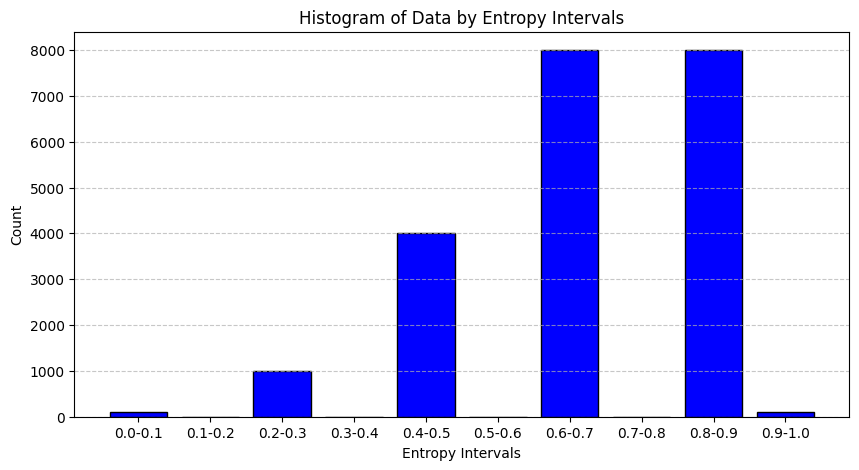

Most common base in 0.0-0.1: zzzzz
Most common base in 0.2-0.3: xzzzz
Most common base in 0.4-0.5: xxzzz
Most common base in 0.6-0.7: xxxzz
Most common base in 0.8-0.9: xxxxz
Most common base in 0.9-1.0: xxxxx


In [36]:
plot_hist_10('hist_5q_1l_e.pkl')

**Interpretation:** For a given number of qubits, on average, the entropy profiles of different random circuits will look very similar (whether entangled or not) to each other (for up to 5 qubits). On average, it looks like the profiles of 3 qubit systems have 4 possible regions, 4 qubit systems have 5 possible regions, and 5 qubit systems have 6 possible regions (with each region receiving roughly the same number of counts for both unentangled and entangled systems). There is also a trend where the 'zzz...' basis is the "least random" basis in terms of entropy, and the 'xxx...' basis is the "most random" basis in terms of entropy. The other bins have most common bases with some permutation of 'x's and 'z's. This suggests that any bases containing 'y' are somewhat "randomly scattered" throughout the bins, as they never appear as the most common base for a particular bin.

# Generating an Entropy Profile for Different Circuits That Have the Same Number of Qubits

In the code below, I gathered the entropy for "num_trials" circuits (each of them should be different), and plotted the entropy profile to see if it aligns with the entropy profiles earlier. My hypothesis is that, on average, the entropy profiles of different circuits will look the same (for circuits with the same number of qubits, and whether entangled or not). For this data, I am using the built-in matplotlib.pyplot hist() function to generate the histogram with 10 bins (because for this purpose, I don't really care about the common bases and am only interested in the profile).

In [22]:
from itertools import product

def gather_results_hist(num_qubits, num_trials, layers, filename) :
    results = []
    bases = xyz_list(num_qubits)
    for i in range(num_trials) : 
        qc = create_periodic_random(num_qubits, num_qubits, layers)
        for b in bases :
            for q in range(num_qubits) :
                if b[q] == 'x' :
                    qc.h(q)
                elif b[q] == 'y' :
                    qc.sdg(q)
                    qc.h(q)
            entropy = calculate_shannon_entropy(qc, num_qubits, False)
            entropy = entropy/num_qubits
            results.append(entropy)
            qc.clear()
    with open(filename, 'wb') as file:
        pickle.dump(results, file)
        

def xyz_list(num):
    
    permutations = product('xyz', repeat=num)
    result = [''.join(p) for p in permutations]
    return result

In [21]:
from itertools import product

def gather_results_hist_entangled(num_qubits, num_trials, layers, filename) :
    results = []
    bases = xyz_list(num_qubits)
    for i in range(num_trials) : 
        qc = create_periodic_random_entangled(num_qubits, num_qubits, layers)
        for b in bases :
            for q in range(num_qubits) :
                if b[q] == 'x' :
                    qc.h(q)
                elif b[q] == 'y' :
                    qc.sdg(q)
                    qc.h(q)
            entropy = calculate_shannon_entropy(qc, num_qubits, False)
            entropy = entropy/num_qubits
            results.append(entropy)
            qc.clear()
    with open(filename, 'wb') as file:
        pickle.dump(results, file)
        

def xyz_list(num):
    
    permutations = product('xyz', repeat=num)
    result = [''.join(p) for p in permutations]
    return result

In [18]:
import matplotlib.pyplot as plt

def plot_hist(filename, bin):  
    arr = []
    with open(filename, 'rb') as file:
        arr = pickle.load(file)
    plt.figure(figsize=(10, 5))
    plt.hist(arr, bins=bin)
    plt.xlabel('Entropy Intervals')
    plt.ylabel('Count')
    plt.title('Histogram of Data by Entropy Intervals')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## Average Profile for 100 Different 3 Qubit Circuits (No Entanglement)

In [23]:
gather_results_hist(3, 100, 1, 'hist_3q_1l_ne_diff.pkl')

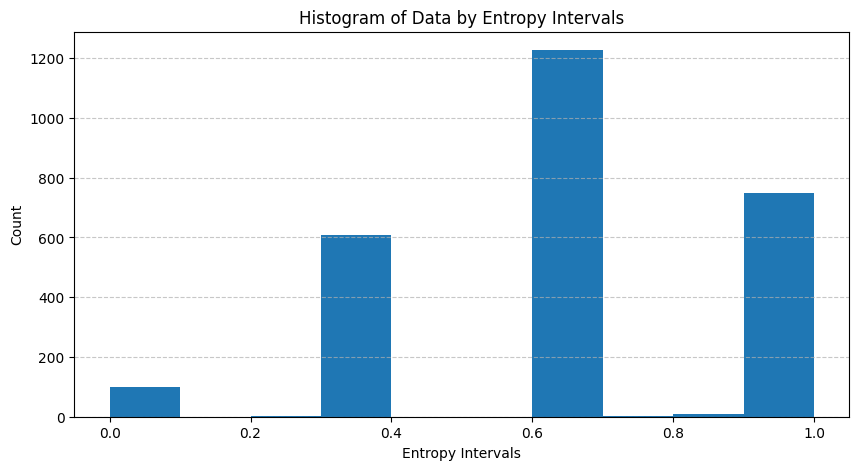

In [24]:
plot_hist('hist_3q_1l_ne_diff.pkl', 10)

## Average Profile for 100 Different 4 Qubit Circuits (No Entanglement)

In [25]:
gather_results_hist(4, 100, 1, 'hist_4q_1l_ne_diff.pkl')

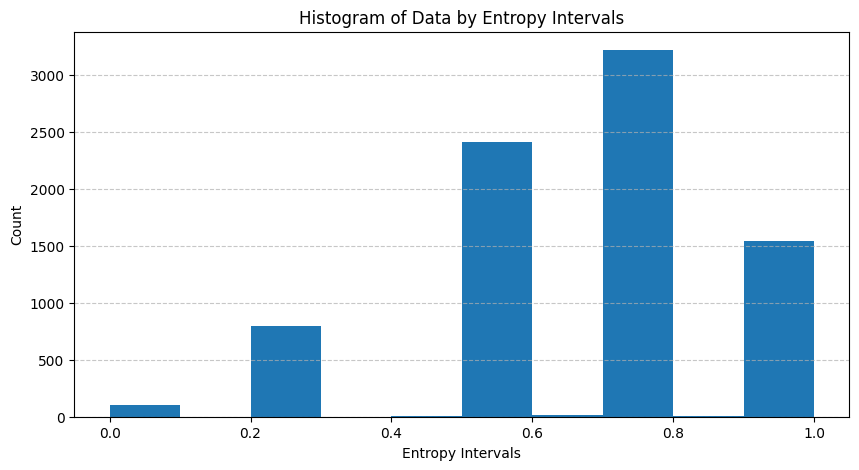

In [26]:
plot_hist('hist_4q_1l_ne_diff.pkl', 10)

## Average Profile for 100 Different 5 Qubit Circuits (No Entanglement)

In [27]:
gather_results_hist(5, 100, 1, 'hist_5q_1l_ne_diff.pkl')

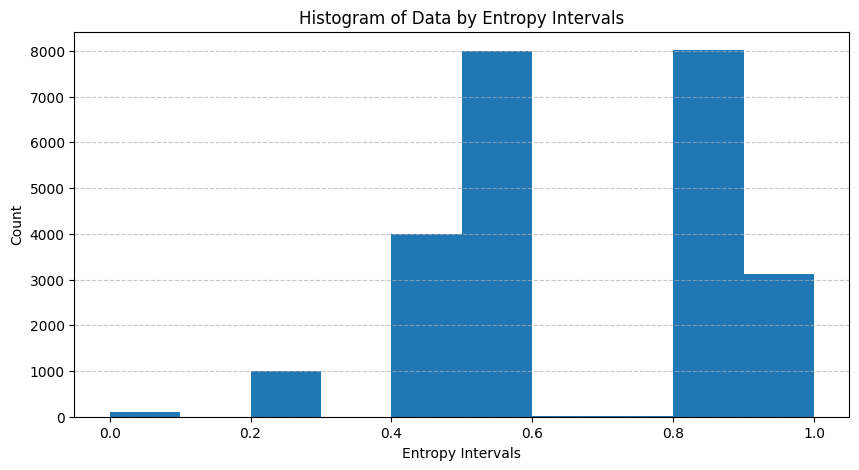

In [28]:
plot_hist('hist_5q_1l_ne_diff.pkl', 10)

## Average Profile for 100 Different 3 Qubit Circuits (With Entanglement)

In [29]:
gather_results_hist_entangled(3, 100, 1, 'hist_3q_1l_e_diff.pkl')

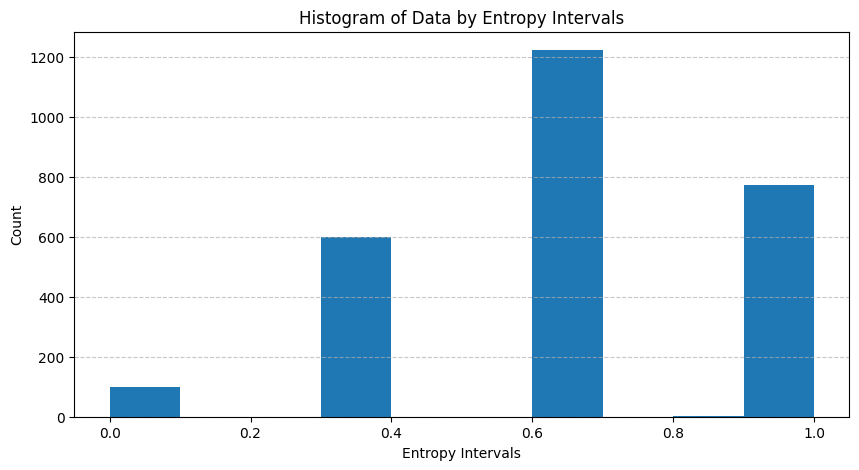

In [30]:
plot_hist('hist_3q_1l_e_diff.pkl', 10)

## Average Profile for 100 Different 4 Qubit Circuits (With Entanglement)

In [31]:
gather_results_hist_entangled(4, 100, 1, 'hist_4q_1l_e_diff.pkl')

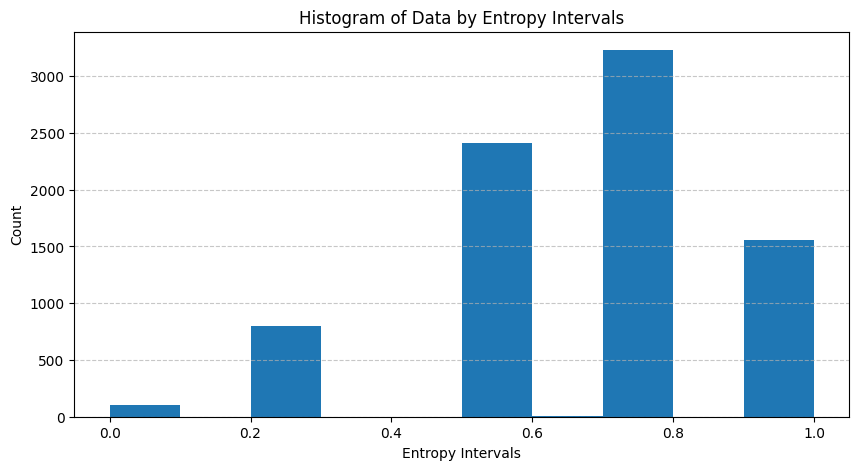

In [32]:
plot_hist('hist_4q_1l_e_diff.pkl', 10)

## Average Profile for 100 Different 5 Qubit Circuits (With Entanglement)

In [33]:
gather_results_hist_entangled(5, 100, 1, 'hist_5q_1l_e_diff.pkl')

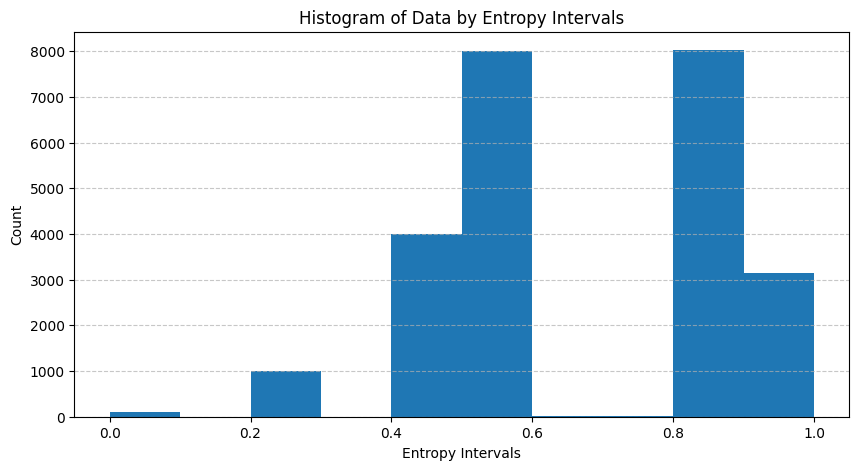

In [34]:
plot_hist('hist_5q_1l_e_diff.pkl', 10)

**Interpretation:** These "average of many different random circuits" entropy profiles all look similar to their respective "single random circuit" entropy profiles from before. Thus, I assert that "on average" the entropy profiles for random circuits of the same number of qubits (for systems of up to 5 qubits--since I did not look at systems of 6 qubits or higher due to a large increase in computation time) look alike, with the only slight discrepancy being which bins the counts are located in (as for 5 qubit systems, the 2 highest counts reside in 2 of the bins that range from 0.5-0.9, but not deterministically the same 2 every time).